In [654]:
%pylab inline
import os

Populating the interactive namespace from numpy and matplotlib


In [655]:
file_root = '/mnt/store1/oliverphilcox/3PCF_QPM/full_run.v01/'

In [887]:
good_mocks=[]
all_zeta = []
all_zeta_uncorr=[]
all_xi = []
gg=[]
for i in range(1,301):
    in_dat = file_root+'3pcf_output_%s.npz'%str(i).zfill(4)
    if os.path.exists(in_dat):
        gg.append(i)
        dat = np.load(in_dat)
        this_zeta = dat.f.zeta*pow(1.5,3)
        this_zeta_uncorr = dat.f.powerD*pow(1.5,3)
        
        #if i in bad_index:
        #    continue
        
        
        if not np.isnan(np.sum(this_zeta)):
            
            if np.abs(np.sum(this_zeta))>1e5:
                continue
            
            good_mocks.append(i)
            
            # normalize correctly
            for b1 in range(len(this_zeta)):
                for b2 in range(b1):
                    this_zeta[b1,b2,1:]*=this_zeta[b1,b2,0]
                    this_zeta_uncorr[b1,b2,1:]*=this_zeta_uncorr[b1,b2,0]
                    # by symmetry
                    this_zeta[b2,b1,:]=this_zeta[b1,b2,:]
                    this_zeta_uncorr[b2,b1,:]=this_zeta_uncorr[b1,b2,:]

#             for ell in range(this_zeta.shape[2]):
#                 this_zeta[:,:,ell]/=(2.*ell+1.)
#                 this_zeta_uncorr[:,:,ell]/=(2.*ell+1.)
                    
            all_zeta.append(this_zeta)
            all_zeta_uncorr.append(this_zeta_uncorr)
            all_xi.append(dat.f.xi*pow(1.5,2))
        else:
            os.remove(in_dat)
            
all_zeta = np.asarray(all_zeta)
all_zeta_uncorr = np.asarray(all_zeta_uncorr)
all_xi = np.asarray(all_xi)

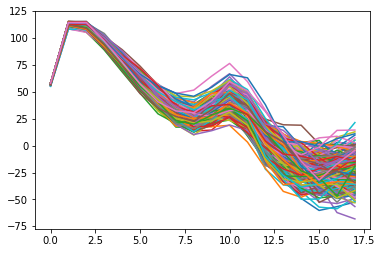

In [888]:
for i in range(n_mocks):
    plt.plot(r_bins**2*all_xi[i])

In [889]:
bad_index=np.asarray(good_mocks)[r_bins[1]**2*all_xi[:,1]<100]

In [890]:
bad_index=np.concatenate([bad_index,[148]])

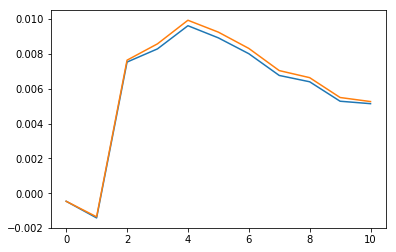

In [891]:
plt.plot(all_zeta[0][5,7])
plt.plot(all_zeta_uncorr[0][5,7])

In [892]:
f=dat.f.f
import scipy.misc as sm

def triplefact(j1,j2,j3):
    jhalf = (j1+j2+j3)/2.0
    return sm.factorial(jhalf) /sm.factorial(jhalf-j1) /sm.factorial(jhalf-j2) /sm.factorial(jhalf-j3)


def threej(j1,j2,j3):
    # Compute {j1,j2,j3; 0,0,0} 3j symbol
    j = j1+j2+j3
    if (j%2>0): return 0     # Must be even
    if (j1+j2<j3): return 0  # Check legal triangle
    if (j2+j3<j1): return 0  # Check legal triangle
    if (j3+j1<j2): return 0  # Check legal triangle
    return (-1)**(j/2.0) * triplefact(j1,j2,j3) / (triplefact(2*j1,2*j2,2*j3)*(j+1))**0.5
    # DJE did

def Mjl_calc(j,ell,flist):
    s=0
    for ellprime in np.arange(1,len(flist)):
        s += (threej(ell,ellprime,j))**2*flist[ellprime]
    s*=(2.*j+1.)
    return s

Mjl = np.zeros((11,11))
for j in range(11):
    for l in range(11):
        Mjl[j,l]=Mjl_calc(j,l,f[9,8])

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  


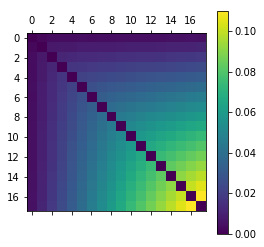

In [893]:
plt.matshow(f[:,:,1]+f[:,:,1].T)
plt.colorbar();

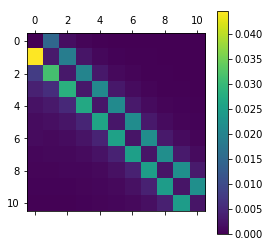

In [894]:
plt.matshow(Mjl);plt.colorbar();

In [895]:
x=np.linalg.inv(np.identity(11)+Mjl)

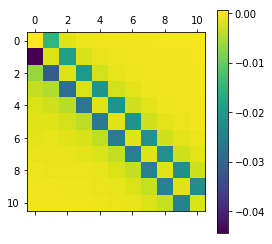

In [896]:
plt.matshow(x-np.identity(11));plt.colorbar();

In [897]:
n_mocks = len(good_mocks)
print("N_mocks = %d"%n_mocks)

N_mocks = 217


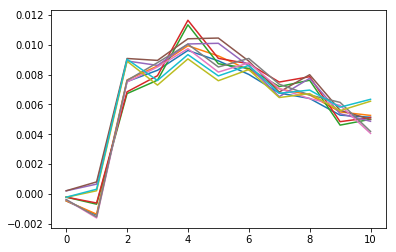

In [898]:
for i in range(5):#n_mocks):
    if i!=69:
        plt.plot(all_zeta[i][5,7,:])
        plt.plot(all_zeta_uncorr[i][5,7,:])

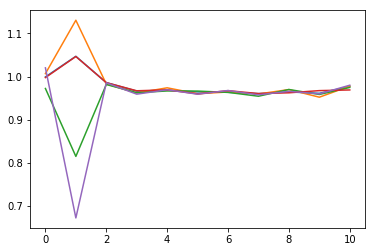

In [940]:
for i in range(5):
    plt.plot(all_zeta[i][5,7,:]/all_zeta_uncorr[i][5,7,:])

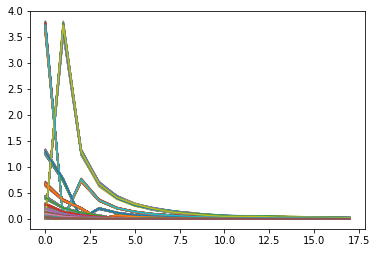

In [900]:
for i in range(n_mocks):
    plt.plot(all_zeta[i][:,:,2])

In [901]:
r_bins = np.linspace(5,175,dat.f.bins)
ells = np.arange(dat.f.order+1)

In [902]:
delta_r = r_bins[1]-r_bins[0]
r_min = r_bins-delta_r/2
n=len(r_min)
min_r_bin = 7

vol_r = 4.*np.pi/3.*((r_min+delta_r)**3-r_min**3)

zeta_compress = np.zeros([n_mocks,len(r_bins)-min_r_bin,dat.f.order+1])

for i in range(n_mocks):
    denom = np.zeros([len(r_bins)-min_r_bin])

    for b1 in range(min_r_bin,n):
        for b2 in range(3,b1-3):
            zeta_compress[i,b1-min_r_bin,:]+=all_zeta[i,b1,b2,:]*vol_r[b2]
            denom[b1-min_r_bin]+=vol_r[b2]
        zeta_compress[i,b1-min_r_bin,:]/=denom[b1-min_r_bin]

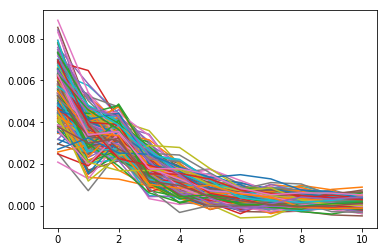

In [903]:
for i in range(n_mocks):
    plt.plot(zeta_compress[i,:,5])

Text(0.5,0,'$r$')

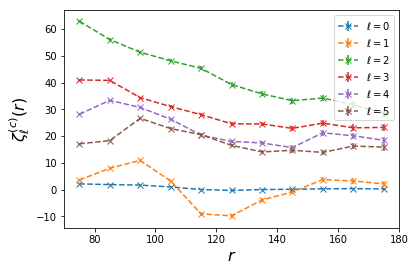

In [904]:
for l_i,ell in enumerate(ells[:6]):
    plt.errorbar(r_bins[min_r_bin:],(r_bins[min_r_bin:]/10.)**4*zeta_compress[:,:,l_i].mean(axis=0),
                 (r_bins[min_r_bin:]/10)**4.*zeta_compress[:,:,l_i].std(axis=0)/np.sqrt(n_mocks),label=r'$\ell=%d$'%(ell),
                marker='x',ls='--')
plt.legend()
plt.ylabel(r'$\zeta^{(c)}_\ell(r)$',fontsize=16)
plt.xlabel(r'$r$',fontsize=16)

# NB: Why are the higher multipoles much bigger than SE paper??

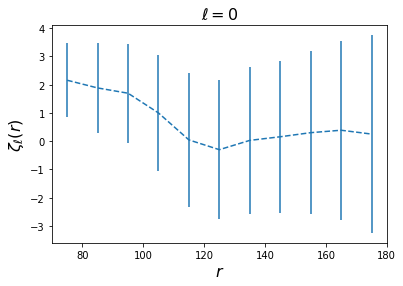

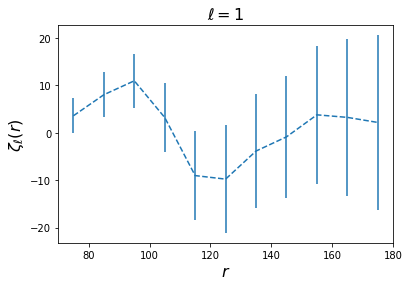

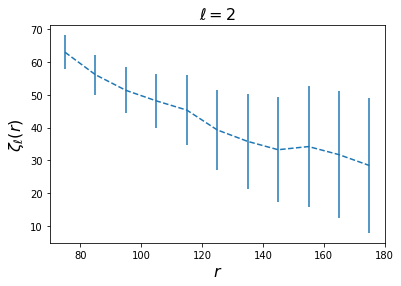

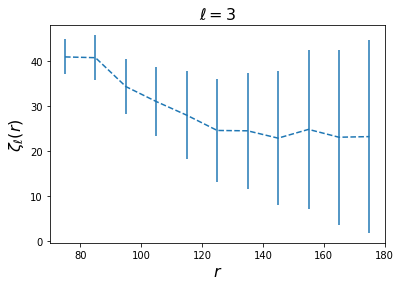

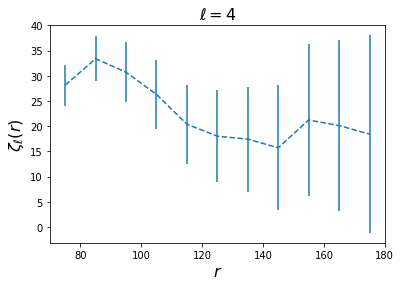

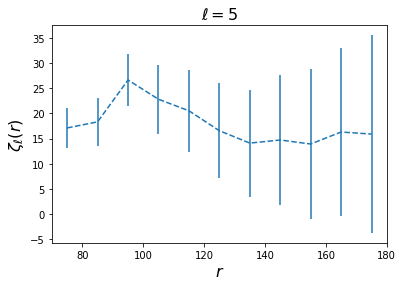

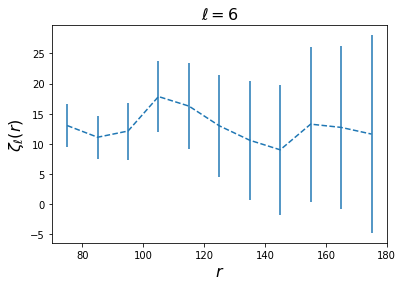

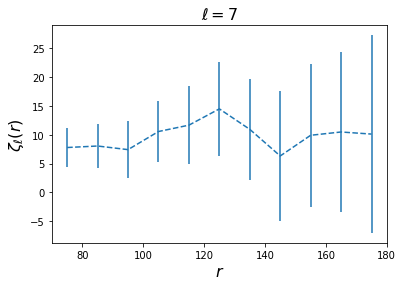

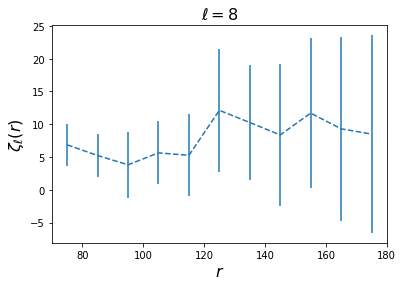

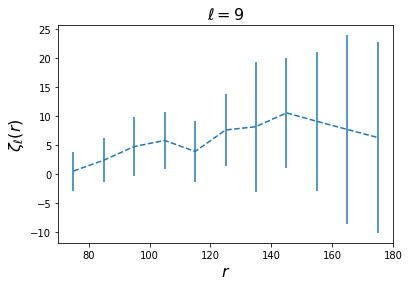

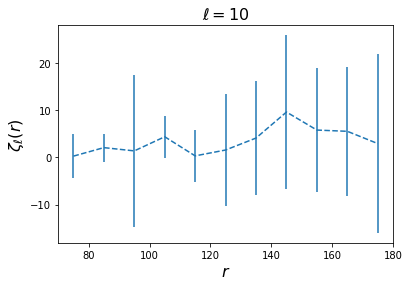

In [938]:
for l_i in ells:
    plt.figure()
    x_dat = r_bins[min_r_bin:]
    y_dat=zeta_compress[:,:,l_i].mean(axis=0)
    y_err=zeta_compress[:,:,l_i].std(axis=0)
    plt.errorbar(x_dat,(x_dat/10.)**4*y_dat,
                 (r_bins[min_r_bin:]/10)**4.*y_err,label=r'$\ell=%d$'%(l_i),
                marker='',ls='--')
    plt.title(r'$\ell = %d$'%l_i,fontsize=16)
    plt.xlabel(r'$r$',fontsize=16)
    plt.ylabel(r'$\zeta_\ell(r)$',fontsize=16)
#plt.legend()

In [906]:
zeta_compress_ravel=[]
for i in range(n_mocks):
    zeta_compress_ravel.append(zeta_compress[i].T.ravel())
zeta_mean = np.mean(np.asarray(zeta_compress_ravel),axis=0)

In [907]:
cov = np.zeros([len(zeta_compress_ravel[0]),len(zeta_compress_ravel[0])])
for i in range(n_mocks):
    diff = zeta_compress_ravel[i]-zeta_mean
    cov+=np.matmul(diff.reshape(-1,1),diff.reshape(1,-1))
cov/=n_mocks-1

In [908]:
red = np.zeros_like(cov)
for i in range(len(cov)):
    for j in range(len(cov)):
        red[i,j]=cov[i,j]/np.sqrt(cov[i,i]*cov[j,j])

## QPM 3PCF Covariance Matrix (250 mocks)

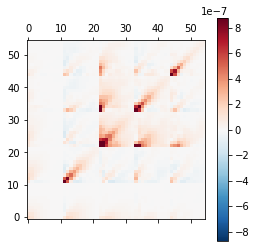

In [909]:
mat=cov
vmax=np.percentile(mat.ravel(),99.9)
plt.matshow(cov,cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax)
plt.xlim([-0.5,55-0.5])
plt.ylim([-0.5,55-0.5])
plt.colorbar();

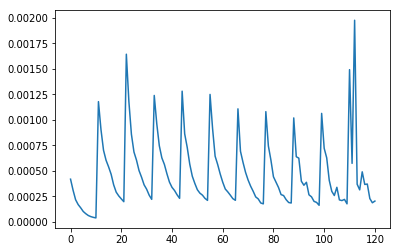

In [910]:
plt.plot(np.sqrt(np.diag(cov)))

In [911]:
np.savez('/mnt/store1/oliverphilcox/3PCF_SE/data_cov_matrix.npz',n_mocks=n_mocks,
        cov=cov)

## Reduced Covariance Matrix

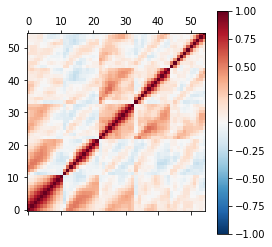

In [912]:
plt.matshow(red,cmap=cm.RdBu_r,vmax=1,vmin=-1)
plt.xlim([-0.5,55-0.5])
plt.ylim([-0.5,55-0.5])
plt.colorbar();

<Figure size 432x288 with 0 Axes>

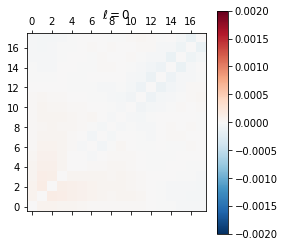

<Figure size 432x288 with 0 Axes>

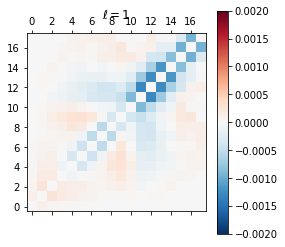

<Figure size 432x288 with 0 Axes>

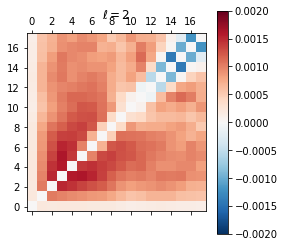

<Figure size 432x288 with 0 Axes>

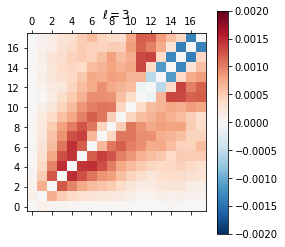

<Figure size 432x288 with 0 Axes>

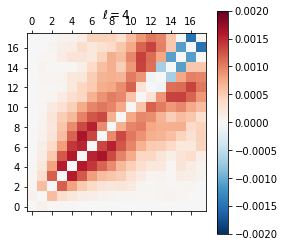

<Figure size 432x288 with 0 Axes>

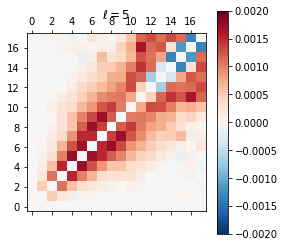

<Figure size 432x288 with 0 Axes>

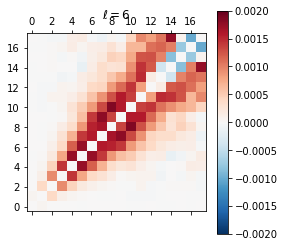

<Figure size 432x288 with 0 Axes>

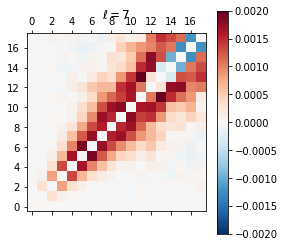

<Figure size 432x288 with 0 Axes>

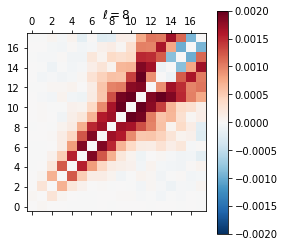

<Figure size 432x288 with 0 Axes>

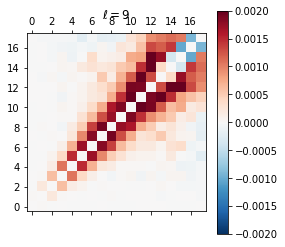

In [933]:
for ell in range(10):
    plt.figure();
    mat=all_zeta.mean(axis=0)[:,:,ell]*(r1r2_sq[:,:]/100**4)
    vmax = 0.002#np.percentile(mat.ravel(),99.9)
    plt.matshow(mat,cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax)
    leng=len(mat)
    plt.xlim([-0.5,leng-0.5])
    plt.ylim([-0.5,leng-0.5])
    plt.colorbar();
    plt.title(r'$\ell = %d$'%ell);

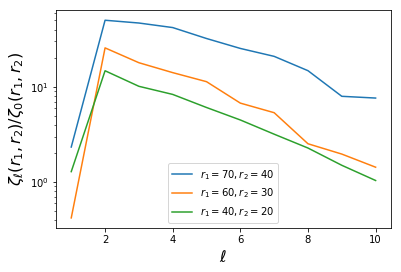

In [934]:
inds = [[7,4],[6,3],[4,2]]
for ind in inds:
    plt.plot(ells[1:],all_zeta.mean(axis=0)[ind[0],ind[1],1:]/all_zeta.mean(axis=0)[ind[0],ind[1],0],
            label=r'$r_1 = %d, r_2 = %d$'%(ind[0]*10,ind[1]*10))
plt.ylabel(r'$\zeta_\ell(r_1,r_2)/\zeta_0(r_1,r_2)$',fontsize=16)
plt.xlabel(r'$\ell$',fontsize=16)
plt.legend();
plt.yscale('log')

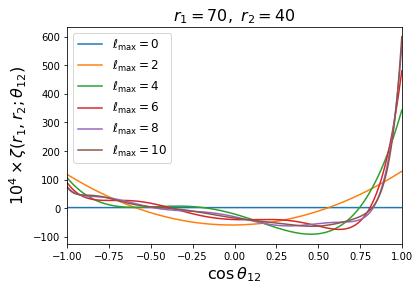

In [935]:
from scipy.special import legendre

for ell_max in [0,2,4,6,8,10]:
    these_ell = np.arange(0,ell_max+1)
    mus = np.arange(-1,1,0.001)
    ddat=[]
    for ell in these_ell:
        ddat.append(legendre(ell)(mus)*all_zeta.mean(axis=0)[7,4][ell])
    dddat = np.sum(np.asarray(ddat),axis=0)
    plt.plot(mus,1e4*dddat,label=r'$\ell_\mathrm{max} = %d$'%ell_max)
plt.legend(fontsize=12);
plt.xlim([-1,1])
plt.xlabel(r'$\cos\,{\theta_{12}}$',fontsize=16)
plt.ylabel(r'$10^4\times \zeta(r_1,r_2;\theta_{12})$',fontsize=16)
plt.title(r'$r_1 = 70,\,\,r_2 = 40$',fontsize=16);

<ErrorbarContainer object of 3 artists>

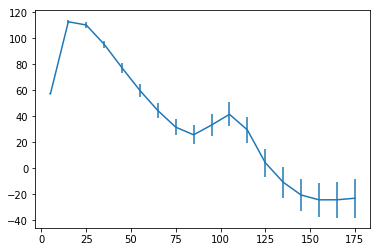

In [936]:
plt.errorbar(r_bins,all_xi.mean(axis=0)*r_bins**2,all_xi.std(axis=0)*r_bins**2,marker='')